In [143]:
from scipy.sparse import csr_matrix
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from quantumScarsCheck import *
from quantumScarsPlotting import *
from quantumScarFunctions import *

N = 10 # IDDEN MAKE SURE TO MAKE THIS AN EVEN NUMBER <-----------------------------------------------------------------------------------------------------------------------------
basisList = binNoConsecOnesEfficient(N)
for basis in basisList:
    if basis[0] == '1' and basis[-1] == '1':
        basisList.remove(basis)
#print(basisList)
    
basisMap = {bitStr: i for i, bitStr in enumerate(basisList)}
# print(basisMap)
basisLen = len(basisList)
flippedList = []
different_omega = 1.0

rowBare = []
columnBare = []

rowFactor = []
columnFactor = []

# flip bit hashmap
flipMap = {'0': '1', '1': '0'}

# sigma z op hashmap
sigzMap = {'0': '-1', '1': '1'}

# list of ints for Hamiltonian
numList = []

# -------------------------------
#
# create the bare PXP hamiltonian
#
# -------------------------------
# the padded variables are not padded
for i in range(basisLen):

    # add padding so that search doesnt go out of range
    paddedBitStr = basisList[i][-1] + basisList[i] + basisList[i][0]
    copyBit = list(paddedBitStr)

    # apply the sum of r P_r-1 * sigma_x * P_r+1 operator
    for j in range(1, N+1):
        
        if paddedBitStr[j-1] == '0' and paddedBitStr[j+1] == '0':
            copyBit[j] = flipMap[paddedBitStr[j]]
            flippedList.append(''.join(copyBit)[1:-1])
            copyBit = list(paddedBitStr)
        
    # adds row and column values for the sparse matrix
    for k in range(len(flippedList)):
        rowBare.append(basisMap[flippedList[k]])
        columnBare.append(i)
        
    flippedList.clear()

# -------------------------------
#
# create the sigma Z PXP hamiltonian perturbation
#
# -------------------------------

# print(basisList)
# print()

for i in range(basisLen):

    # add padding so that search doesnt go out of range
    paddedBitStr = basisList[i][-2] + basisList[i][-1] + basisList[i] + basisList[i][0] + basisList[i][1]
    copyBit = list(paddedBitStr)
    factor = 1

    # apply the PXP operator
    for j in range(2, N+2):
        
        if (paddedBitStr[j-1] == '0') and (paddedBitStr[j+1] == '0'):
            copyBit[j] = flipMap[paddedBitStr[j]]

            # apply sigmaZ_r-2 + sigmaZ_r+2
            r_neg2 = int(sigzMap[paddedBitStr[j-2]])
            r_pos2 = int(sigzMap[paddedBitStr[j+2]])
            factor = r_neg2 + r_pos2
            numList.append(factor)

            flippedList.append(''.join(copyBit)[2:-2])
            copyBit = list(paddedBitStr)
        
    # print(flippedList)

    # adds row and column values for the sparse matrix
    for k in range(len(flippedList)):
        rowFactor.append(basisMap[flippedList[k]])
        columnFactor.append(i)
        
    flippedList.clear()

# list of ones for the sparse matrix
onesList = np.ones(len(rowBare), dtype=int)

# create the sparse matrix and turn it into a Qobj
sparseBareHamiltonian = csr_matrix((onesList, (rowBare, columnBare)), shape=[basisLen, basisLen])
matrixBareHamiltonian = sparseBareHamiltonian.toarray()

sparseFactoredHamiltonian = csr_matrix((numList, (rowFactor, columnFactor)), shape=[basisLen, basisLen])
matrixFactoredHamiltonian = sparseFactoredHamiltonian.toarray()

H0 = (different_omega / 2 * sparseBareHamiltonian) + (-0.026 * different_omega * sparseFactoredHamiltonian)

# print()
# print(H0)

H0 = qt.Qobj(H0)

# -------------------------------
#
# states and evolutions set ups
#
# -------------------------------

# diagonalize the sparse matrix
eigenvalues, eigenstates = H0.eigenstates()

# initial state
z2_str = z2_initial(N)
#print(z2_str)
z2_index = basisMap[z2_str]
psi0 = qt.basis(basisLen, z2_index)

# time evolution of sparse matrix
tlist = np.linspace(0, 400, 500)
evolState = qt.sesolve(H0, psi0, tlist)

# -------------------------------
#
# create the driving hamiltonian
#
# -------------------------------

# create H1 operator for QobjEvo!
copyBasis = basisList
diagH1 = []

# switches 0s to -1s and keeps 1s the same for the copyBasis
# appends to diagH1 the dot product between each bit string and the 0 -> -1 Z2 state
for i in range(basisLen):

    bitString = list(copyBasis[i])
    bitString = [int(i) for i in bitString]

    z2bitString = list(z2_initial(N))
    z2bitString = 2 * np.array([int(i) for i in z2bitString]) - 1

    diagH1.append(np.dot(2 * np.array(bitString) - 1, z2bitString))

# rows and columns lists for diagonal positions in H1
rowH1 = [i for i in range(basisLen)]
columnH1 = [i for i in range(basisLen)]

# creates sparse matrix with diagonals as diagH1 list
H1 = csr_matrix((diagH1, (rowH1, columnH1)), shape=[basisLen, basisLen])
H1 = qt.Qobj(H1)


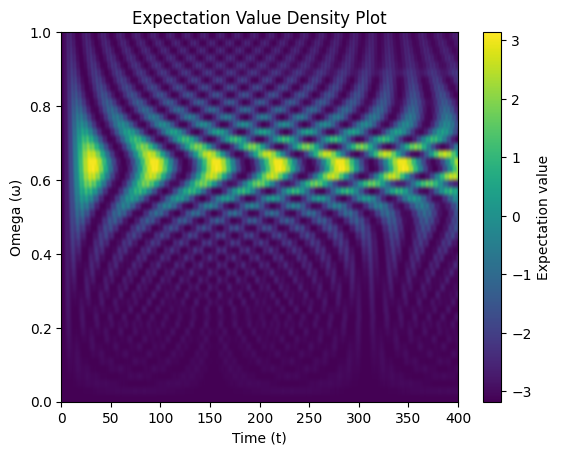

In [144]:
# plot the expectation values of the sparse matrix throughout time with different omega
wlist = np.linspace(0.0, 1.0, 50)
expectationVals = []
tempExpectation = []

for omega in wlist:

    args = {"A": 0.1, "omega": omega}
    H = qt.QobjEvo([H0, [H1, coeff]], args=args) # create H using QobjEvo
    psi_t = qt.sesolve(H, eigenstates[0], tlist) # evolve the H through time
    tempExpectation = []

    for states in psi_t.states:

        val = states.dag() * H0 * states
        tempExpectation.append(val.real)

    expectationVals.append(tempExpectation)

plt.imshow(expectationVals,
           extent=[tlist.min(), tlist.max(), wlist.min(), wlist.max()],
           origin='lower',
           aspect='auto',
           cmap='viridis')
plt.colorbar(label="Expectation value")

plt.xlabel("Time (t)")
plt.ylabel("Omega (ω)")
plt.title("Expectation Value Density Plot")
plt.savefig("plots//expectDensityPlot.pdf")
plt.show()

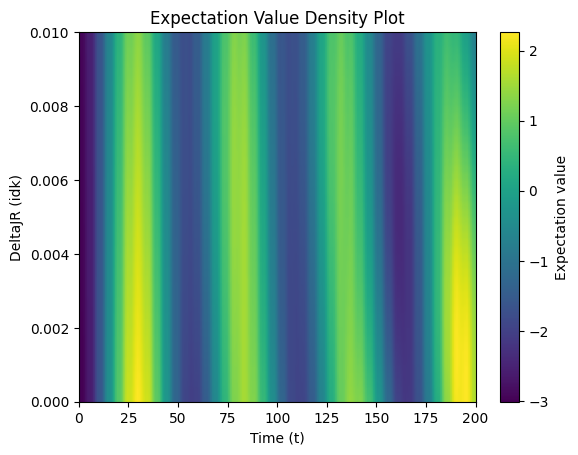

In [157]:
# plot the expectation values of the sparse matrix throughout time with different JR
jrList = np.linspace(0.0, 0.01, 50)
tlist = np.linspace(0, 200, 200)
expectationVals = []
tempExpectation = []

for jr in jrList:

    jrH0 = (different_omega / 2 * sparseBareHamiltonian) + (jr * different_omega * sparseFactoredHamiltonian)
    jrH0 = qt.Qobj(jrH0)

    args = {"A": 0.1, "omega": 0.642570281124498}
    H = qt.QobjEvo([jrH0, [H1, coeff]], args=args) # create H using QobjEvo
    psi_t = qt.sesolve(H, eigenstates[0], tlist) # evolve the H through time
    tempExpectation = []

    for states in psi_t.states:

        val = states.dag() * jrH0 * states
        tempExpectation.append(val.real)

    expectationVals.append(tempExpectation)

plt.imshow(expectationVals,
           extent=[tlist.min(), tlist.max(), jrList.min(), jrList.max()],
           origin='lower',
           aspect='auto',
           cmap='viridis')
plt.colorbar(label="Expectation value")

plt.xlabel("Time (t)")
plt.ylabel("DeltaJR (idk)")
plt.title("Expectation Value Density Plot")
# plt.savefig("plots//expectDensityPlot.pdf")
plt.show()

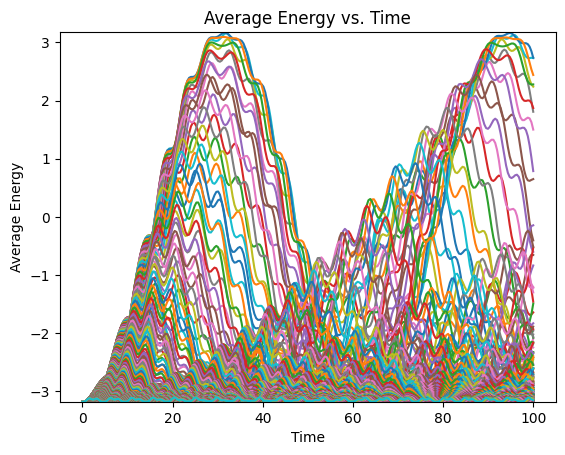

In [158]:
tlist_limited = np.linspace(0, 100, 250)
wlist_limited = np.linspace(0, 2, 250)
expectationVals_limited = {}
tempExpectation_limited = []

plt.figure()

for omega in wlist_limited:

    args = {"A": 0.1, "omega": omega}
    H = qt.QobjEvo([H0, [H1, coeff]], args=args) # create H using QobjEvo
    psi_t = qt.sesolve(H, eigenstates[0], tlist_limited) # evolve the H through time
    tempExpectation_limited = []

    for states in psi_t.states:

        val = states.dag() * H0 * states
        tempExpectation_limited.append(val.real)
    
    expectationVals_limited[omega] = tempExpectation_limited

for omega in wlist_limited:
    plt.plot(tlist_limited, expectationVals_limited[omega], label=f"$\\omega = {omega:.2f}$")

plt.xlabel("Time")
plt.ylabel("Average Energy")
plt.title("Average Energy vs. Time")
plt.ylim(eigenvalues[0], eigenvalues[-1])
# plt.legend()
plt.show()

In [159]:
# find wc - omega with the highest average energy peak
wc_potential = {}

for omega in wlist_limited:
    wc_potential[omega] = max(expectationVals_limited[omega])

best_omega = max(wc_potential, key=wc_potential.get)
wc_omega_pair = {float(best_omega): wc_potential[best_omega]}

print(wc_omega_pair)
# 10 qubits: 0.6385542168674698

{0.642570281124498: 3.16871677346329}


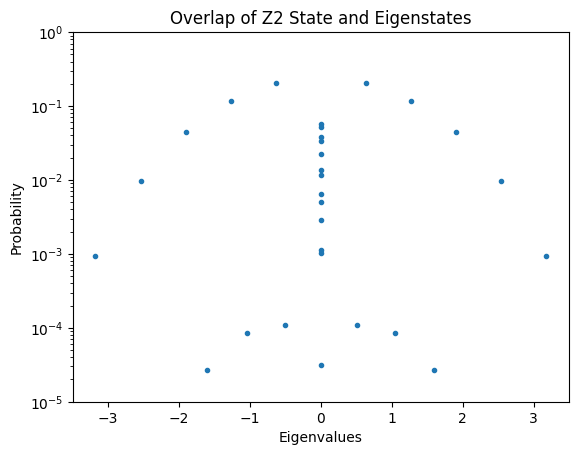

In [160]:
plotAmpEigenstatesZ2Log(H0, psi0)

In [161]:
plotProbZ2Time(H0, psi0, t=50)
plotProbZ2Time(qt.Qobj(omega / 2 * matrixBareHamiltonian), psi0, t=50)


TypeError: plotProbZ2Time() got an unexpected keyword argument 't'